# Automatic Text Redaction for Government Documents

This notebook contains the code to run the experiments in the TPDL short paper "Detection of Redacted Text in Legal Documents", as well as instructions on how to work with the datasets that we have provided in the GitHub repository. We also provide code to run the complete algorithm on new images, to compute some statistics of the pages, and to time the algorithm.


## Index
1. [Text Redaction Algorithm](#algorithm)
    - 1.1 [Preprocessing](#preprocessing)
    - 1.2 [Text Removal](#text_removal)
    - 1.3 [Contour Detection](#contour_detection)
    - 1.4 [Contour Filtering](#contour_filtering)
2. [Algorithm Performance](#performance)
    - [Model Scores](#scores)
    - [Processing Times](#time)

In [1]:
# Imports
import cv2
import json
import time
import pytesseract
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from pytesseract import Output
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

%matplotlib inline

<a id="algorithm" />

## Detection Algorithm

Below we will implement the detection algorithm in separate functions, and show the output per step. The complete algorithm is also described in the paper. If you want to run this algorithm for you own purposes, check out the scripts in the `scripts` folder of this repository, they provide a lot of helper functions to make it easy to work with the code.

In [2]:
# Let's load in a test iamge with some nice redaction blocks to work with
test_image = '../datasets/images/woo-niet-evacueren-medewerkers-atvet-documenten012-001.png'

In [3]:
# Simply load the PNG images
def load_image(image_path: str) -> np.ndarray:
    """
    Function that loads an image from a path.
    :param image_path: string specifying the path to the image
    :return: Numpy array with the image in BGR format.
    """
    # Checking if it is an image
    if image_path.lower().endswith('.png'):
        # Load the image in BGR format
        image = cv2.imread(image_path)
    return image

Let's have a look at the test image, and see what we have, we have to rearrange the channels if we plot with matplotlib as their function expects an RGB image.

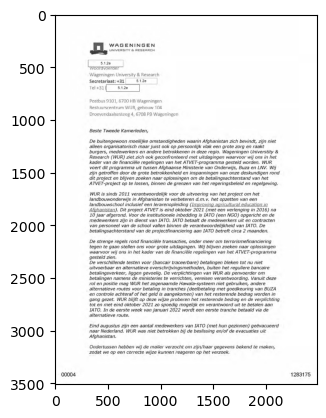

In [4]:
plt.imshow(load_image(test_image)[:, :, ::-1]) # change channels to rgb for visualization
plt.show()

After the file load, we will start by doing the preprocessing, where we do this both for the text recognition, and the box recognition.

In [5]:
# load the test image for the further operations
test_array = load_image(test_image)

<a id="preprocessing" />

## Preprocessing

As described in the paper, for the text processing we convert the image to grayscale, after which we apply the closing operation (dilation followed by erosion, to close some holes in text). For the redaction box preprocessing we will also convert the image to grayscale, and we will apply two opening operations, both horizontally and vertically, after which we apply a Gaussian blur.

In [6]:
def text_preprocessing(image: np.ndarray, text_pre_closing_kernel_size: tuple = (2, 2),
                      text_pre_guassian_blur_size: tuple = (3, 3)) -> np.ndarray:
    """
    :param image: Numpy array representing the input image in BGR format.
    :return: Numpy array with a grayscale image after applied operations.
    Method that applies image preprocessing for input to Tesseract, performs the following
    operations:
    1. Conversion of the iamge to grayscale
    2. Closing of the image with a 2 by 2 kernel to remove noise.
    3. Guassian blur with a 3 by 3 kernel.
    """
    # First we convert the input image to grayscale
    image_grayscale = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    # We set up a kernel for the closing operation
    kernel = np.ones(text_pre_closing_kernel_size, np.uint8)
    
    # we perform closing, i.e. dilation followed by erosion
    closed_image = cv2.morphologyEx(image_grayscale, cv2.MORPH_CLOSE, kernel)
    
    # Finally we use a Guassian blur over the image with a 3 by 3 kernel size
    image_blurred = cv2.GaussianBlur(closed_image, ksize=text_pre_guassian_blur_size, sigmaX=0)

    return image_blurred

In [7]:
def redaction_box_preprocessing(image: np.ndarray, box_pre_horizontal_closing_size: tuple = (1, 3),
                               box_pre_vertical_closing_size: tuple=(3, 1),
                               box_pre_bilat_filter_size: int = 5,
                               box_pre_filter_sigma_color: int = 75,
                               box_pre_filter_sigma_space: int=75) -> np.ndarray:
    """
    :param image: Numpy array representing the input image in BGR format.
    :return: Numpy array with a grayscale image after applied operations.
    Method that applies image preprocessing for input the morphological operations, performs the following
    operations:
    1. Conversion of the iamge to grayscale
    2. Horizontal opening with a 1 by 3 kernel
    3. Vertical opening with a 3 by 1 kernel
    3. Bilateral filter.
    """
    # First we convert the input image to grayscale
    image_grayscale = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    # We perform two sets of opening operations, a horizontal one, followed by a vertical one.
    horizontal_kernel = np.ones(box_pre_horizontal_closing_size, np.uint8)
    horizontally_opened_image = cv2.morphologyEx(image_grayscale, cv2.MORPH_OPEN, horizontal_kernel)
    
    # Apply kernel vertically over the horizontally opened image
    vertical_kernel = np.ones(box_pre_vertical_closing_size, np.uint8)
    vertically_opened_image = cv2.morphologyEx(horizontally_opened_image, cv2.MORPH_OPEN, vertical_kernel)

    # Perform a bilateral blur
    bilateral_blurred_image = cv2.bilateralFilter(vertically_opened_image, box_pre_bilat_filter_size,
                                                  box_pre_filter_sigma_color, box_pre_filter_sigma_space)

    return bilateral_blurred_image


In [8]:
image_text_pre, image_box_pre = text_preprocessing(test_array), redaction_box_preprocessing(test_array)

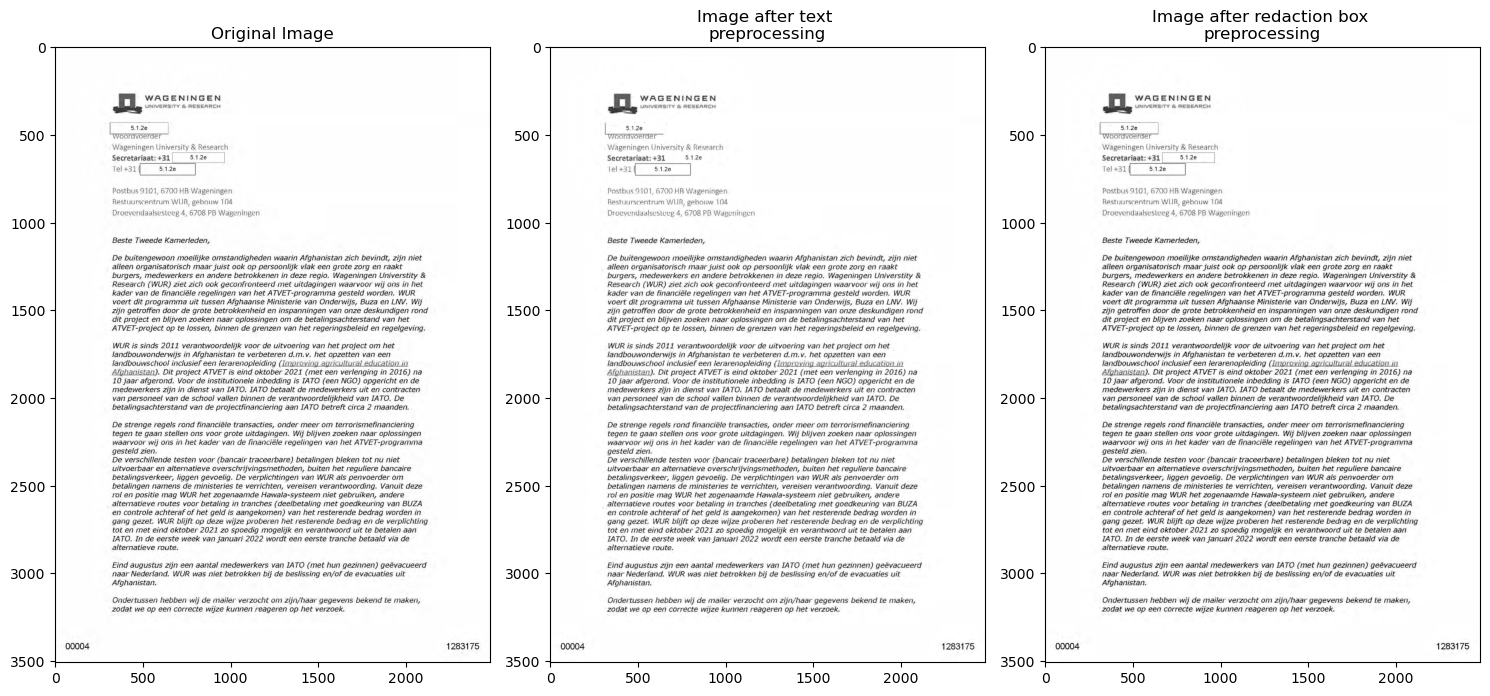

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

axes[0].imshow(test_array[:, : , ::-1])
axes[0].set_title("Original Image")
axes[1].imshow(image_text_pre, cmap='gray', vmin=0, vmax=255)
axes[2].imshow(image_box_pre, cmap='gray', vmin=0, vmax=255)
axes[1].set_title("Image after text \npreprocessing")
axes[2].set_title("Image after redaction box \npreprocessing")
plt.tight_layout()
plt.show()

In the image above we can see the two preprocessing steps applied, where the difference between the diferent images is not very big, apart from of course the conversion to grayscale.

<a id="text_removal" />

## Text Removal

In this step we remove the text from the image using Tesseract, where we will take care not to include any of the codes such as `5.1.1` and `5.1.2` in the detection of text, otherwise these redaction boxes would get removed and would not be able to be detected later on.

In [10]:
def remove_text(text_image: np.ndarray, redaction_box_image: np.ndarray,
               tesseract_confidence: int = 65):
    # Count the total number of pixes of the pages occupied by words
    words_area = 0
    # Make a copy of the image where we will apply our transformation to.
    image_without_text = redaction_box_image.copy()
    # Get the width and height of the images
    image_height, image_width = redaction_box_image.shape[:2]

    # Set up the code to detect the leftmost and rightmost pieces of a page.
    left_boundary = [image_width]
    right_boundary = [0]
    top_boundary = [image_height]
    bottom_boundary = [0]

    # Specify the codes we want to detect
    codes = ['5.1.1.', '5.1.2.']

    # run tesseract on the image preprocessed for text
    tesseract_output = pytesseract.image_to_data(text_image, lang='nld+eng', output_type=Output.DICT)
    
    # Get the height of the text
    height = np.array(tesseract_output['height'])
    # get the median height of the text, we will use this to calculate
    # how much of the page is occupied by words
    median_text_height = np.median(height[height < 0.3*image_height])

    # Get the number of detected text pages
    number_of_boxes = len(tesseract_output['level'])
    for box in range(number_of_boxes):
        # Get the coordinates of the text box if it actually contain any text
        if (tesseract_output['text'][box].strip() != "") and (tesseract_output['conf'][box] != -1) and (tesseract_output['height'][box] < 0.3*image_height):
            (x, y, w, h) = (tesseract_output['left'][box], tesseract_output['top'][box], tesseract_output['width'][box], tesseract_output['height'][box])

            # If the text contains one of the codes we want to keep it and not remove it
            # from the page
            if any([code in tesseract_output['text'][box] for code in codes]):
                # If the text is longer we want to adjust the width to include more specific subcodes
                if len(tesseract_output['text'][box]) > 7:
                    sub_index = tesseract_output['text'][box].find('5.1.')
                    char_width = w / len(tesseract_output['text'][box])
                    w = int(char_width * 7)
                    x += int(char_width * sub_index)
                # make the redaction boxes a white color
                cv2.rectangle(image_without_text, (x, y), (x + w, y + h), (0, 0, 0), -1)
            # If its not a redaction box and the confidence is high enough
            # remove the text from hte page
            elif tesseract_output['conf'][box] > tesseract_confidence:
                words_area += (w*h)
                cv2.rectangle(image_without_text, (x, y), (x + w, y + h), (255, 255, 255), -1)

                if median_text_height*1.1 > tesseract_output['height'][box] > median_text_height*0.9:
                    left_boundary.append(x)
                    right_boundary.append(x+w)
                    top_boundary.append(y)
                    bottom_boundary.append(y+h)

    image_without_text = cv2.threshold(image_without_text, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    return image_without_text, words_area, {'left_boundary': min(left_boundary),
                                'right_boundary': max(right_boundary),
                                'top_boundary': min(top_boundary),
                               'bottom_boundary': max(bottom_boundary)}

In [11]:
image_without_text, total_word_area, text_boundaries = remove_text(text_preprocessing(test_array), redaction_box_preprocessing(test_array))

Let's plot the image without the text and only the bounding boxes of what we have left.

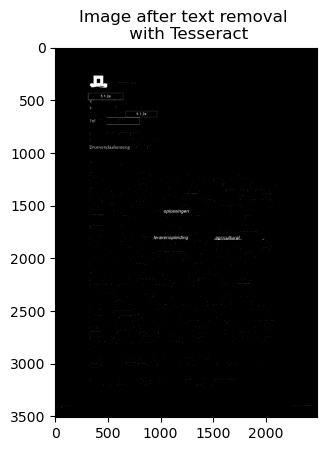

In [12]:
plt.imshow(image_without_text, cmap='gray', vmin=0, vmax=255)
plt.title("Image after text removal \n with Tesseract")
plt.show()

This already looks quite good, but we can see that there is some text that did not get detected properly, such as at the bottom of the page and all the way at the top. In the next step we will get the contours of the redacted text and do some more filtering to get rid of these pieces of text.

<a id="contour_detection" />

## Contour Detection

After the text removal, we are going to clear the image up a bit more with more closing operations, after which we will extract the new contours.


In [13]:
def determine_contours(image_without_text: np.ndarray, contour_opening_kernel_size: tuple = (5, 5)):

    # Find the contours we have so far and fill them so we can perform more operations on them
    contours = cv2.findContours(image_without_text, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    for contour in contours:
        # filll contours with white
        cv2.drawContours(image_without_text, [contour], -1, (255,255,255), -1)

    # Here we remove noise by using an opening operation
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, contour_opening_kernel_size)
    opened_image = cv2.morphologyEx(image_without_text, cv2.MORPH_OPEN, kernel, iterations=4)

    # Draw rectangles
    new_contours = cv2.findContours(opened_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    new_contours = new_contours[0] if len(new_contours) == 2 else new_contours[1]
    
    return opened_image, new_contours

In [14]:
image_with_contours, contours = determine_contours(image_without_text)

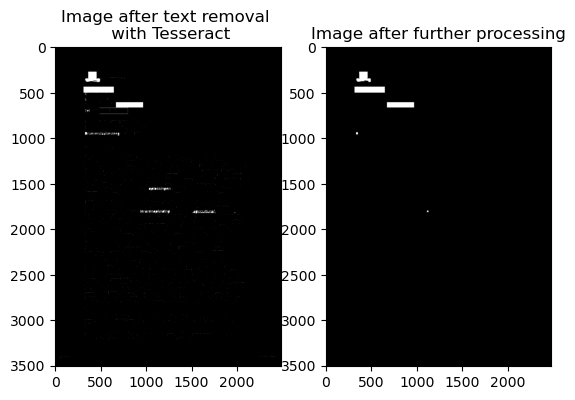

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(image_without_text, cmap='gray', vmin=0, vmax=255)
axes[1].imshow(image_with_contours, cmap='gray', vmin=0, vmax=255)
axes[0].set_title("Image after text removal \n with Tesseract")
axes[1].set_title("Image after further processing")
plt.show()

As we can see, some of the text that was missed by Tesseract has been properly removed now. The final step is a filtering step on these contours once again, now removing contours that are too small, or contours that are not rectangular.

<a id="contour_filtering" />

## Final Filtering Step

In [16]:
def filter_contours(original_image: np.ndarray, contours: list, text_boundaries: dict):
    
    final_image = original_image.copy()
    final_contour_image = np.zeros([original_image.shape[0], original_image.shape[1]], dtype=np.uint8)
    
    # set thresholds for the sizes of the bounding boxes that we are going to keep
    area_treshold_min = 0.000125 * original_image.shape[0] * original_image.shape[1]
    area_treshold_max = 0.4 * original_image.shape[0] * original_image.shape[1]

    left_text_boundary = [text_boundaries['left_boundary']]
    right_text_boundary = [text_boundaries['right_boundary']]
    top_text_boundary = [text_boundaries['top_boundary']]
    bottom_text_boundary = [text_boundaries['bottom_boundary']]
    
    # boolean indicating if there is any redacted text on the page
    redacted_bool = False
    number_of_redacted_regions = 0
    total_contour_area = 0
    # save the final contours
    final_contours = []

    for contour in contours:
        # Find extreme points of contours
        contour_left = tuple(contour[contour[:, :, 0].argmin()][0])
        contour_right = tuple(contour[contour[:, :, 0].argmax()][0])
        contour_top = tuple(contour[contour[:, :, 1].argmin()][0])
        contour_bottom = tuple(contour[contour[:, :, 1].argmax()][0])

        # Filter out rectangles that are too small, or where the height is bigger than the width
        if area_treshold_max > cv2.contourArea(contour) > area_treshold_min and ((contour_bottom[1] - contour_top[1]) < (contour_right[0] - contour_left[0])):
            
            final_contours.append(contour)
            # add the contours into the final image
            cv2.drawContours(final_image, [contour], -1, (0,255, 0), thickness=5)
            cv2.drawContours(final_contour_image, [contour], -1, (255, 255, 255), -1)

            left_text_boundary.append(contour_left[0])
            right_text_boundary.append(contour_right[0])
            top_text_boundary.append(contour_top[1])
            bottom_text_boundary.append(contour_bottom[1])
            
            total_contour_area += cv2.contourArea(contour)
            number_of_redacted_regions += 1

    text_area = ((max(right_text_boundary) - min(left_text_boundary)) * (max(bottom_text_boundary) - min(top_text_boundary)))

    
    return final_image, final_contour_image, final_contours, total_contour_area, text_area

In [17]:
final_image_with_contours, final_contour_image, final_contours, total_contour_area, total_text_area  = filter_contours(test_array, contours, text_boundaries)

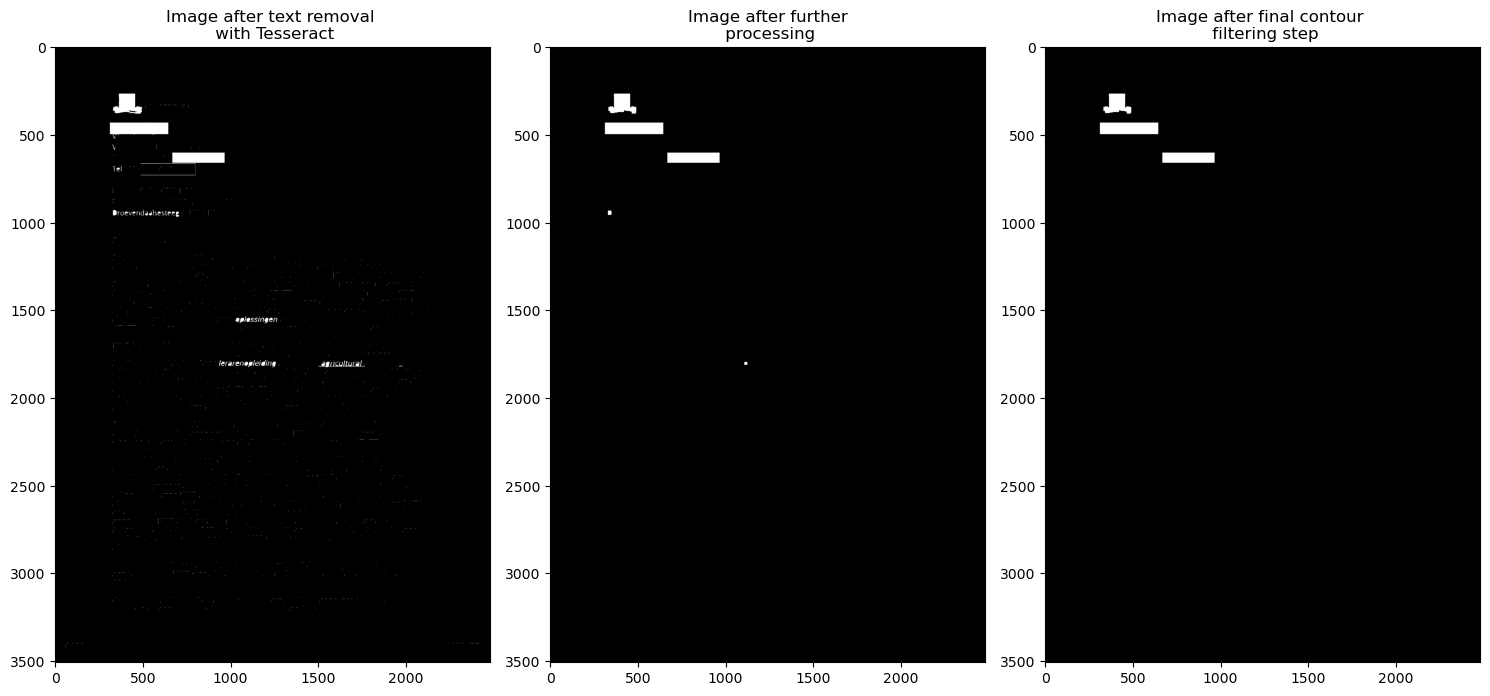

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
axes[0].imshow(image_without_text, cmap='gray', vmin=0, vmax=255)
axes[1].imshow(image_with_contours, cmap='gray', vmin=0, vmax=255)
axes[2].imshow(final_contour_image, cmap='gray', vmin=0, vmax=255)
axes[0].set_title("Image after text removal \n with Tesseract")
axes[1].set_title("Image after further\n processing")
axes[2].set_title("Image after final contour \n filtering step")
plt.tight_layout()
plt.show()

Above we can now see that final step of the algorithm, and indeed some of the very small areas have now also been removed (the small score in the top center of the image for example).

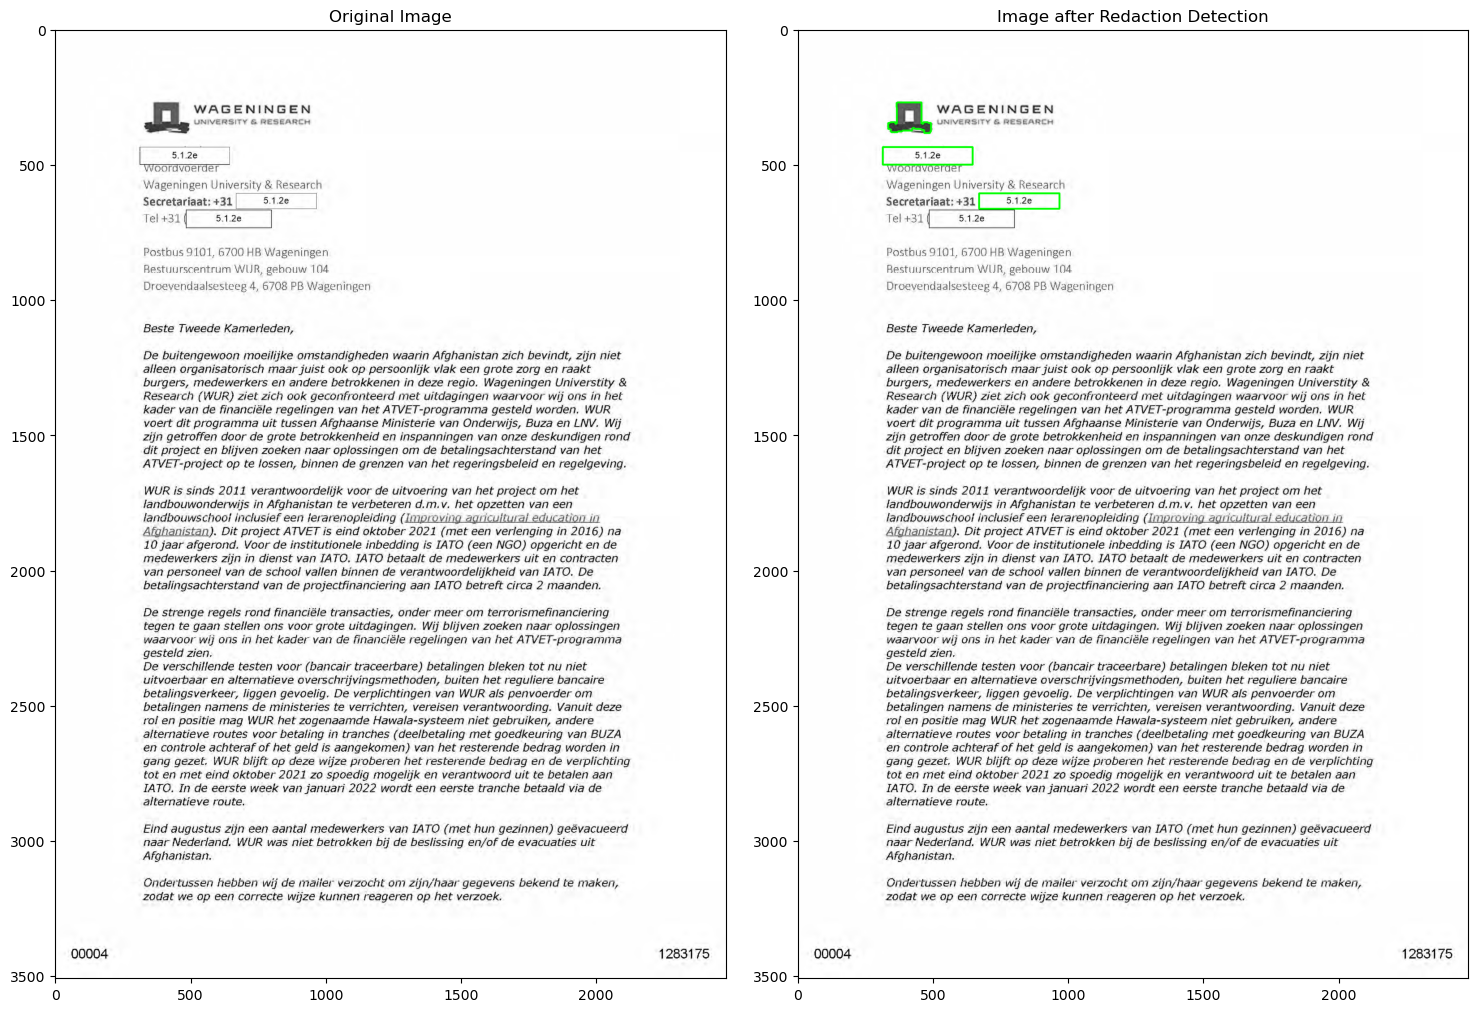

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

axes[0].imshow(test_array[:, :, :])
axes[0].set_title("Original Image")
axes[1].imshow(final_image_with_contours)
axes[1].set_title("Image after Redaction Detection")
plt.tight_layout()
plt.show()

We also provide a small function to run the algorithm and plot all steps, together with a complete function to run the algorithm that also contains all the parameters used in the functions so that you can experiment with different things yourself.

In [21]:
def run_algorithm(input_image_path: str,
                  text_pre_closing_kernel_size: tuple = (2, 2),
                  text_pre_guassian_blur_size: tuple = (3, 3),
                  box_pre_horizontal_closing_size: tuple = (1, 3),
                  box_pre_vertical_closing_size: tuple = (3, 1),
                  box_pre_bilat_filter_size: int = 5,
                  box_pre_filter_sigma_color: int = 75,
                  box_pre_filter_sigma_space: int = 75,
                  tesseract_confidence: int = 65,
                  contour_opening_kernel_size: tuple = (5, 5)):
    """
    This functions implements the complete redaction detection algorithm and contains the options
    to set the parameters used as to experiment with different settings.
    :param input_image_path: string specifying the path to the input image
    :param text_pre_closing_kernel_size: size of the closing kernel for the text preprocessing step
    :param text_pre_guassian_blur_size: size of the kernel for the Gaussian blur for the text
    preprocessing step
    :param box_pre_horizontal_closing_size: size of the horizontal closing operation for the redaction 
    box preprocessing step
    :param box_pre_vertical_closing_size:size of the vertical closing operation for the redaction 
    box preprocessing step
    :param box_pre_bilat_filter_size: Size of the bilateral filter kernel for the redaction box
    preprocssing step.
    :param box_pre_filter_sigma_color: color sigma ofr the bilateral filter of the redaction box
    preprocessing step
    :param box_pre_filter_sigma_space: space sigma ofr the bilateral filter of the redaction box
    preprocessing ste
    :param tesseract_confidence: integer specifying the confidence level for Tesseract to 
    consider something to be text
    :param contour_opening_kernel_size: kernel size of the opening operation in the contour detection step.
    """
    
    input_image = load_image(input_image_path)
    # Do the preprocessing
    image_text_pre = text_preprocessing(input_image, text_pre_closing_kernel_size)
    
    image_box_pre = redaction_box_preprocessing(input_image, 
                                                box_pre_horizontal_closing_size,
                                                box_pre_vertical_closing_size,
                                                box_pre_bilat_filter_size,
                                                box_pre_filter_sigma_color,
                                                box_pre_filter_sigma_space)
    # Remove the text
    image_without_text, total_words_area, text_boundaries = remove_text(image_text_pre, image_box_pre,
                                                                       tesseract_confidence)
    # First contour detection step
    image_with_contours, contours = determine_contours(image_without_text, contour_opening_kernel_size)
    # final contouring filtering step
    final_image_with_contours, final_contour_image, final_contours, total_contour_area, total_text_area  = filter_contours(input_image, contours, text_boundaries)
    
    # Automatically calculate some statistics on the number of redacted boxes, and the total percentage of 
    # the page that is redacted.
    # Check how much of the text area is redacted (%)
    percentage_redacted_textarea = ((total_contour_area / total_text_area) * 100) if total_contour_area and total_text_area else 0

    # Check how much of character area is redacted (%)
    total_area = total_contour_area + total_words_area
    percentage_redacted_words = ((total_contour_area / total_area) * 100) if total_contour_area else 0
    num_of_redacted_regions = len(final_contours)
    
    return final_contours, percentage_redacted_words, num_of_redacted_regions

In [22]:
def visualize_algorithm_steps(input_image_path):
    fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(15, 10))
    
    input_image = load_image(input_image_path)
    # Do the preprocessing
    image_text_pre, image_box_pre = text_preprocessing(input_image), redaction_box_preprocessing(input_image)
    # Remove the text
    image_without_text, total_words_area, text_boundaries = remove_text(image_text_pre, image_box_pre)
    # First contour detection step
    image_with_contours, contours = determine_contours(image_without_text)
    # final contouring filtering step
    final_image_with_contours, final_contour_image, final_contours, total_contour_area, total_text_area  = filter_contours(input_image, contours, text_boundaries)
    
    axes[0].imshow(input_image)
    axes[1].imshow(image_text_pre, cmap='gray', vmin=0, vmax=255)
    axes[2].imshow(image_box_pre, cmap='gray', vmin=0, vmax=255)
    axes[3].imshow(image_without_text, cmap='gray', vmin=0, vmax=255)
    axes[4].imshow(image_with_contours, cmap='gray', vmin=0, vmax=255)
    axes[5].imshow(final_contour_image, cmap='gray', vmin=0, vmax=255)
    axes[6].imshow(final_image_with_contours)
    
    axes[0].set_title("Original image")
    axes[1].set_title("Text Preprocessing")
    axes[2].set_title("Redaction Box\n Preprocessing")
    axes[3].set_title("Text Removal")
    axes[4].set_title("Contour Detection")
    axes[5].set_title("Contour Filtering")
    axes[6].set_title("Final Image ")
    
    plt.tight_layout()
    plt.show()

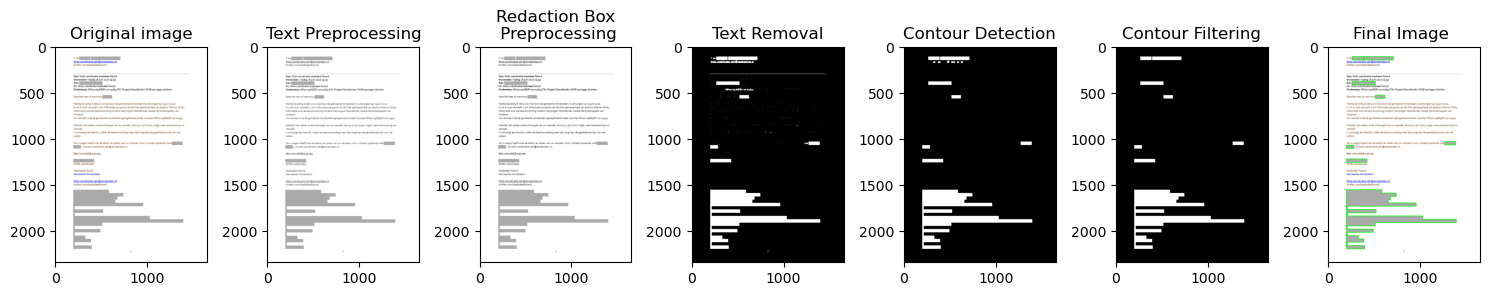

In [23]:
visualize_algorithm_steps('../datasets/images/wob-verzoek_project_noordeinde-963416-page1.png')

Now that we have the algorithm to detect redacted text in place, we can start using this to get some statistics of the page. We will write a small function that you can use to calculate these statistics per page.

<a id="performance" />

## Measuring model performance

In this part of the notebook we will run the scores on the testsets and evaluate using PQ. For this, we will be using the `annotations.json` file, which contains the annotations of the redacted text contours of the images. After this we will also time the different parts of the algorithm so that we get a clear understanding of what parts of the algorithms are most time consuming.

In [24]:
import json
def read_json(file_name):
    with open(file_name, 'r') as json_file:
        return json.load(json_file)

In [25]:
# Load in the files containing all the gold standard regions 
gold_standard = read_json('../datasets/gold_standard.json')

In [26]:
# rewrite this to just work with only the output polygons
def evaluate_detection(input_image_filename):
    gold_standard_contours = gold_standard[input_image_filename.split('/')[-1]]
    predicted_contours, _, _ = run_algorithm(input_image_filename)
    
    # Get the attributes of all the boxes in the gold standard annotation
    polygons = [r['shape_attributes'] for r in gold_standard_contours['regions']]

    # set the total sum of the IOU
    sum_IoU = 0
    TP = []
    FN = []
    FP = []

    predicted_polygons = [Polygon(np.squeeze(contour)) for contour in predicted_contours]
    ground_truth_polygons = []
    
    for polygon in polygons:
        if polygon['name'] == 'rect':
            bottom_left = [polygon['x'], polygon['y']]
            bottom_right = [polygon['x']+polygon['width'], polygon['y']]
            top_right = [polygon['x']+polygon['width'], polygon['y']+polygon['height']]
            top_left = [polygon['x'], polygon['y']+polygon['height']]
            
            gold_standard_polygon_xy = [bottom_left, bottom_right, top_right, top_left]
        else:
            # If not a rectangle we have a more complex shape and we just add all points to it
            gold_standard_polygon_xy  = [[polygon['all_points_x'][i], polygon['all_points_y'][i]] for i in range(0, len(polygon['all_points_x']))]

        ground_truth_polygons.append(Polygon(gold_standard_polygon_xy))
        
    # Loop over all of the predicted and ground truth polygons and check if there
    # is enough overlap to be a True Positive
    for predicted_polygon in predicted_polygons:
        for ground_truth_polygon in ground_truth_polygons:
            polygon_intersection = predicted_polygon.intersection(ground_truth_polygon).area
            polygon_union = predicted_polygon.area + ground_truth_polygon.area - polygon_intersection
        
            if (polygon_intersection / polygon_union) >= 0.5:
                sum_IoU += (polygon_intersection / polygon_union)
                TP.append([ground_truth_polygon, predicted_polygon])

    # Calculate false positives, false negatives and true positives and the PQ
    # score.
    FP = [polygon for polygon in predicted_polygons if polygon not in [item[1] for item in TP]]
    FN = [polygon for polygon in ground_truth_polygons if polygon not in [item[0] for item in TP]]
    
    return {'TP': len(TP), 'FP': len(FP), 'FN': len(FN), 'IOU': sum_IoU}
    


<a id="scores" />

## Evaluation Using PQ

To evaluate on all the images, we have to load in the types of redacted text (which are also present in the json file). We then count the TP, FN, and FP for all images, and use this to calculate the final scores. We will work with dataframes here, as this is the easiest way to assign labels to the different pages. For the definition of the PQ metric, please see the original paper from Kirilov et al.

In [27]:
page_csv = pd.read_csv('../datasets/data.csv')

In [28]:
def evaluate_dataframe(image_dataframe):
    all_scores = {}
    for _, row in tqdm(image_dataframe.iterrows()):
        path = '../datasets/images/%s' % row['File']
        image_scores = evaluate_detection(path)
        all_scores[row['File']] = image_scores
    return all_scores

In [29]:
all_scores = evaluate_dataframe(page_csv)

170it [05:06,  1.80s/it]


In [30]:
page_csv = page_csv.set_index('File')
results = pd.DataFrame(all_scores).T
#add the scores and statistic to the dataframe
complete_dataframe = page_csv.join(results)

In [31]:
def metric_calculation(dataframe):
    # We calculate the metrics over the total of each class, basically viewing the 
    # complete class as one big image.
    
    SQ = dataframe['IOU'].sum() / dataframe['TP'].sum()
    RQ = dataframe['TP'].sum() / (dataframe['TP'].sum() + 0.5*dataframe['FN'].sum() + 0.5*dataframe['FP'].sum())
    PQ = SQ*RQ
    P = dataframe['TP'].sum() / (dataframe['TP'].sum() + dataframe['FP'].sum())
    R = dataframe['TP'].sum() / (dataframe['TP'].sum() + dataframe['FN'].sum())
    
    number_of_segments =  dataframe['TP'] + dataframe['FN']
    dataframe['num_segments'] = number_of_segments
    return round(SQ, 2), round(RQ, 2) , round(PQ, 2), round(P, 2), round(R, 2), dataframe
                                

In [32]:
# Make the results table, where we group based on redaction type.
type_results_table = {}
for _, df in complete_dataframe.groupby('label'):
    SQ, RQ, PQ, P, R, dataframe = metric_calculation(df)
    redacted_type = df['label'].tolist()[0]
    type_results_table[redacted_type] = {'SQ': SQ, 'RQ': RQ, 'PQ': PQ, 'P': P, 'R': R}

In [33]:
pd.DataFrame(type_results_table).T

,SQ,RQ,PQ,P,R
black,0.92,0.79,0.72,0.84,0.74
border,0.93,0.76,0.71,0.85,0.69
color,0.89,0.85,0.76,0.82,0.89
gray,0.90,0.70,0.63,0.77,0.64


<a id="time" />

## Timing the  complete function

To time the algorithm we wrote a small script that can time the execution times of individual functions so we can report them in the paper.

In [34]:
def time_algorithm(input_image_path):
    load_start = time.time()
    input_image = load_image(input_image_path)
    load_end = time.time()
    # Do the preprocessing
    pre_start = time.time()
    image_text_pre, image_box_pre = text_preprocessing(input_image), redaction_box_preprocessing(input_image)
    pre_end = time.time()
    # Remove the text
    remove_start = time.time()
    image_without_text, _, text_boundaries = remove_text(image_text_pre, image_box_pre)
    remove_end = time.time()
    # First contour detection step
    contour_det_start = time.time()
    image_with_contours, contours = determine_contours(image_without_text)
    contour_det_end = time.time()
    # final contouring filtering step
    final_step_start = time.time()
    final_image_with_contours, final_contour_image, final_contours, _, total_text_area  = filter_contours(input_image, contours, text_boundaries)
    final_step_end = time.time()
    
    times = {'loading': load_end-load_start,
            'preprocessing': pre_end-pre_start,
           'text_removal': remove_end-remove_start,
           'contour detection': contour_det_end-contour_det_start,
           'final filtering': final_step_end-final_step_start}
    
    times['total'] = sum(times.values())
    
    return times

In [ ]:
# do this over all the images and average
load_times = []
preprocessing_times = []
text_removal_times = []
contour_detection_times = []
final_filtering_times = []
total_times = []

for image_path in tqdm(glob('../datasets/**/*.png')):
    times = time_algorithm(image_path)
    load_times.append(times['loading'])
    preprocessing_times.append(times['preprocessing'])
    text_removal_times.append(times['text_removal'])
    contour_detection_times.append(times['contour detection'])
    final_filtering_times.append(times['final filtering'])
    total_times.append(times['total'])
    

 86%|███████████████████████████████████      | 148/173 [04:06<00:42,  1.68s/it]

In [ ]:
print("Average loading time is %.3f seconds" % np.mean(load_times))
print("Average preprocessing time is %.3f seconds" % np.mean(preprocessing_times))
print("Average text removal time is %.3f seconds" % np.mean(text_removal_times))
print("Average contour detection time is %.3f seconds" % np.mean(contour_detection_times))
print("Average final filtering time is %.3f seconds" % np.mean(final_filtering_times))